In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [27]:
# Function to load multiple CSV files into a single DataFrame
def load_multiple_csv(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = [pd.read_csv(file) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [30]:
# Define folder paths for Smart Meter and Non-Smart Meter data
smart_meter_folder = r"data\EC2\smart_meter_data"
non_smart_meter_file = r"data\EC2\non_smart_meter_data.csv"

# Load Smart Meter data
smart_meter_data = load_multiple_csv(smart_meter_folder)

# Load Non-Smart Meter data
non_smart_meter_data = pd.read_csv(non_smart_meter_file)

C:\Users\Gayanuka Amarasuriya\AppData\Local\Temp\ipykernel_25188\3573793461.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(file) for file in all_files]
C:\Users\Gayanuka Amarasuriya\AppData\Local\Temp\ipykernel_25188\3573793461.py:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(file) for file in all_files]


In [31]:
# Load EC1 supporting datasets
demographics = pd.read_csv('data\EC1\w1_demographics.csv')
appliances = pd.read_csv('data\EC1\w1_appliances.csv')
electricity_gen = pd.read_csv('data\EC1\w1_electricity_generation_water_heating_cooking.csv')
fan_roster = pd.read_csv('data\EC1\w1_fan_roster.csv')
household_info = pd.read_csv('data\EC1\w1_household_information_and_history.csv')
light_roster = pd.read_csv('data\EC1\w1_light_roster.csv')
room_roster = pd.read_csv('data\EC1\w1_room_roster.csv')

C:\Users\Gayanuka Amarasuriya\AppData\Local\Temp\ipykernel_25188\279011407.py:8: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  room_roster = pd.read_csv('data\EC1\w1_room_roster.csv')


In [33]:
# Merge supporting datasets into one
ec1_data = pd.concat([demographics, appliances, electricity_gen, fan_roster, household_info, light_roster, room_roster], axis=1)

# Ensure 'Month' column exists in both DataFrames
if 'Month' not in smart_meter_data.columns:
	smart_meter_data['Month'] = np.nan  # or any default value

if 'Month' not in non_smart_meter_data.columns:
	non_smart_meter_data['Month'] = np.nan  # or any default value

# Combine Smart and Non-Smart Meter Data
combined_data = pd.merge(smart_meter_data, non_smart_meter_data, on=['household_ID', 'Month'], how='outer')

In [35]:
# Convert relevant columns to numeric types
combined_data['TR1_TOTAL_IMPORT (kWh)'] = pd.to_numeric(combined_data['TR1_TOTAL_IMPORT (kWh)'], errors='coerce')
combined_data['TR2_TOTAL_IMPORT (kWh)'] = pd.to_numeric(combined_data['TR2_TOTAL_IMPORT (kWh)'], errors='coerce')
combined_data['TR3_TOTAL_IMPORT (kWh)'] = pd.to_numeric(combined_data['TR3_TOTAL_IMPORT (kWh)'], errors='coerce')
combined_data['TOTAL_IMPORT (kWh)'] = pd.to_numeric(combined_data['TOTAL_IMPORT (kWh)'], errors='coerce')
combined_data['TOTAL_EXPORT (kWh)'] = pd.to_numeric(combined_data['TOTAL_EXPORT (kWh)'], errors='coerce')

# Derive new metrics
combined_data['day_peak_ratio'] = combined_data['TR1_TOTAL_IMPORT (kWh)'] / combined_data['TR2_TOTAL_IMPORT (kWh)']
combined_data['off_peak_efficiency'] = combined_data['TR3_TOTAL_IMPORT (kWh)'] / combined_data['TOTAL_IMPORT (kWh)']
combined_data['generation_consumption_ratio'] = combined_data['TOTAL_EXPORT (kWh)'] / combined_data['TOTAL_IMPORT (kWh)']

# Handle missing or infinite values resulting from derived metrics
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(subset=['day_peak_ratio', 'off_peak_efficiency', 'generation_consumption_ratio'], inplace=True)

In [36]:
# Normalize data for clustering
features = ['day_peak_ratio', 'off_peak_efficiency', 'generation_consumption_ratio']
scaler = StandardScaler()
combined_data_scaled = scaler.fit_transform(combined_data[features])

In [37]:


# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
combined_data['cluster'] = kmeans.fit_predict(combined_data_scaled)

# Determine efficiency boundaries
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
combined_data['efficiency_status'] = combined_data['cluster'].apply(lambda x: 'efficient' if x == np.argmax(cluster_centers[:, 1]) else 'inefficient')


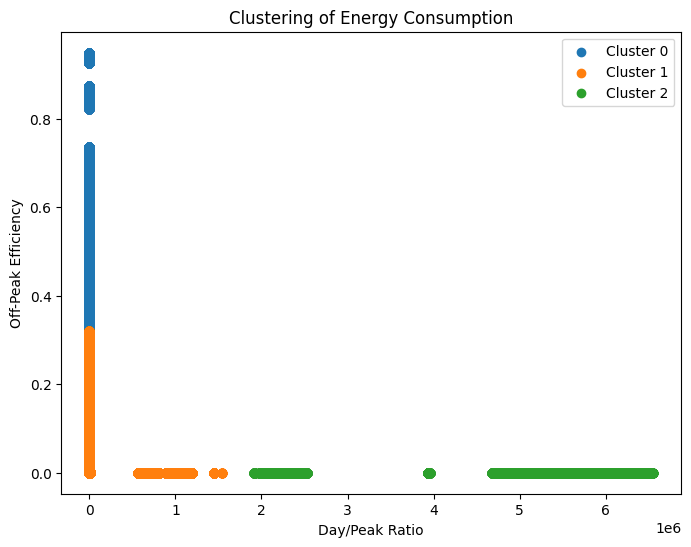

In [39]:
# Visualize Clustering
plt.figure(figsize=(8, 6))
for cluster in range(3):
    subset = combined_data[combined_data['cluster'] == cluster]
    plt.scatter(subset['day_peak_ratio'], subset['off_peak_efficiency'], label=f'Cluster {cluster}')
plt.xlabel('Day/Peak Ratio')
plt.ylabel('Off-Peak Efficiency')
plt.title('Clustering of Energy Consumption')
plt.legend()
plt.show()

In [ ]:
# Evaluate clustering
sil_score = silhouette_score(combined_data_scaled, combined_data['cluster'])
print(f"Silhouette Score: {sil_score}")

# Identify inefficient households
inefficient_households = combined_data[combined_data['efficiency_status'] == 'inefficient']
print(f"Number of Inefficient Households: {inefficient_households.shape[0]}")
print(inefficient_households[['household_ID', 'efficiency_status']])